In [4]:
# =====================================================
# HÜCRE 1 – KÜTÜPHANELERİ YÜKLEME
# Bu hücrede:
# - Veri işleme, modelleme ve görselleştirme için gerekli kütüphaneler yüklenir.
# - Warnings (uyarı mesajları) kapatılır.
# =====================================================

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve, precision_recall_fscore_support
)

from scipy.sparse import hstack

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

print("Tüm kütüphaneler yüklendi.")


Tüm kütüphaneler yüklendi.


In [5]:
# =====================================================
# HÜCRE 2 – VERİYİ YÜKLEME VE HEDEF DEĞİŞKENİN OLUŞTURULMASI
# Bu hücre:
# 1) CSV dosyasını okur
# 2) Başlık (title) alanı boş olan satırları temizler
# 3) is_hourly sütununu 0 (Fixed) / 1 (Hourly) yapar
# =====================================================

csv_path = "all_upwork_jobs_2024-02-07-2024-03-24.csv"

# CSV dosyasını oku
df = pd.read_csv(csv_path, low_memory=False)

# Başlığı olmayan satırları at
df = df.dropna(subset=["title"]).copy()

# is_hourly sütununu 0/1'e çeviren fonksiyon
def map_hourly(v):
    s = str(v).strip().lower()
    if s in ["1", "true", "yes", "y", "hourly"]:
        return 1
    elif s in ["0", "false", "no", "n", "fixed"]:
        return 0
    return np.nan

# Dönüşümü uygula
df["is_hourly"] = df["is_hourly"].apply(map_hourly)

# is_hourly olmayan satırları temizle
df = df.dropna(subset=["is_hourly"]).copy()

# Hedef değişken
y = df["is_hourly"].astype(int)

print(f"Veri: {df.shape}, Fixed: {(y==0).sum():,}, Hourly: {(y==1).sum():,}")


Veri: (244827, 8), Fixed: 103,891, Hourly: 140,936


In [6]:
# =====================================================
# HÜCRE 3 – ÖZELLİK OLUŞTURMA VE TF-IDF
# Bu hücre:
# 1) Başlık uzunluğu, kelime sayısı gibi sayısal özellikleri üretir
# 2) Bütçe, saatlik ücret ve ülke bilgisinden ek özellikler çıkarır
# 3) Title metinlerini TF-IDF ile vektörleştirir
# 4) Metin ve sayısal özellikleri tek matris altında birleştirir
# =====================================================

# Başlık uzunlukları
df["title_length"] = df["title"].astype(str).str.len()
df["word_count"] = df["title"].astype(str).str.split().str.len()

# Bütçe ve saatlik ücret var mı?
df["has_budget"] = df["budget"].notna().astype(int)
df["has_hourly"] = df["hourly_low"].notna().astype(int)

# Ortalama saatlik ücret (varsa)
df["avg_hourly"] = df[["hourly_low", "hourly_high"]].mean(axis=1).fillna(0)

# Bütçe boşsa 0 ile doldur
df["budget_filled"] = df["budget"].fillna(0)

# En sık görülen 10 ülkeyi al, diğerlerini "Other" yap
top_countries = df["country"].value_counts().head(10).index.tolist()
df["country_grouped"] = df["country"].apply(
    lambda x: x if x in top_countries else "Other"
).fillna("Unknown")

# Ülkeleri sayıya çevir
le_country = LabelEncoder()
df["country_encoded"] = le_country.fit_transform(df["country_grouped"])

# TF-IDF ile metin (title) özellikleri (1500 yerine 1000 yapılabilir, hız için)
tfidf = TfidfVectorizer(max_features=1000, stop_words="english")
X_text = tfidf.fit_transform(df["title"].astype(str))

# Sayısal özellik kolonları
numeric_cols = [
    "title_length", "word_count", "has_budget",
    "has_hourly", "country_encoded", "avg_hourly", "budget_filled"
]
X_numeric = df[numeric_cols].values

# Metin ve sayısal özellikleri birleştir
X = hstack([X_text, X_numeric])

print(f"{X.shape[1]} özellik, Train/Test ayrımına hazır.")


1007 özellik, Train/Test ayrımına hazır.


In [7]:
# =====================================================
# HÜCRE 3 – ÖZELLİK OLUŞTURMA VE TF-IDF
# Bu hücre:
# 1) Başlık uzunluğu, kelime sayısı gibi sayısal özellikleri üretir
# 2) Bütçe, saatlik ücret ve ülke bilgisinden ek özellikler çıkarır
# 3) Title metinlerini TF-IDF ile vektörleştirir
# 4) Metin ve sayısal özellikleri tek matris altında birleştirir
# =====================================================

# Başlık uzunlukları
df["title_length"] = df["title"].astype(str).str.len()
df["word_count"] = df["title"].astype(str).str.split().str.len()

# Bütçe ve saatlik ücret var mı?
df["has_budget"] = df["budget"].notna().astype(int)
df["has_hourly"] = df["hourly_low"].notna().astype(int)

# Ortalama saatlik ücret (varsa)
df["avg_hourly"] = df[["hourly_low", "hourly_high"]].mean(axis=1).fillna(0)

# Bütçe boşsa 0 ile doldur
df["budget_filled"] = df["budget"].fillna(0)

# En sık görülen 10 ülkeyi al, diğerlerini "Other" yap
top_countries = df["country"].value_counts().head(10).index.tolist()
df["country_grouped"] = df["country"].apply(
    lambda x: x if x in top_countries else "Other"
).fillna("Unknown")

# Ülkeleri sayıya çevir
le_country = LabelEncoder()
df["country_encoded"] = le_country.fit_transform(df["country_grouped"])

# TF-IDF ile metin (title) özellikleri (1500 yerine 1000 yapılabilir, hız için)
tfidf = TfidfVectorizer(max_features=1000, stop_words="english")
X_text = tfidf.fit_transform(df["title"].astype(str))

# Sayısal özellik kolonları
numeric_cols = [
    "title_length", "word_count", "has_budget",
    "has_hourly", "country_encoded", "avg_hourly", "budget_filled"
]
X_numeric = df[numeric_cols].values

# Metin ve sayısal özellikleri birleştir
X = hstack([X_text, X_numeric])

print(f"{X.shape[1]} özellik, Train/Test ayrımına hazır.")


1007 özellik, Train/Test ayrımına hazır.


In [8]:
# =====================================================
# HÜCRE 4 – TRAIN/TEST AYIRIMI
# Bu hücre:
# 1) X ve y'yi eğitim ve test setlerine böler
# 2) Stratify ile sınıf oranlarının korunmasını sağlar
# =====================================================

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"{X.shape[1]} özellik, Train: {X_train.shape[0]:,}, Test: {X_test.shape[0]:,}")


1007 özellik, Train: 195,861, Test: 48,966


In [9]:
# =====================================================
# HÜCRE 5 – SKLEARN MODELLERİ (LOGISTIC REG., RANDOM FOREST, GNB)
# Bu hücre:
# 1) Logistic Regression
# 2) Random Forest
# 3) Gaussian Naive Bayes
# modellerini eğitir ve test seti performanslarını hesaplar.
# GridSearch aralıkları biraz daraltılarak eğitim süresi kısaltılmıştır.
# =====================================================

print("\n" + "="*70)
print("SKLEARN MODELLERİ")
print("="*70)

sklearn_results = []

# ---------------------------
# 1) Logistic Regression
# ---------------------------
print("\n1. Logistic Regression...")

lr_params = {
    "C": [0.1, 1.0],      # 0.1,1,10 → 0.1,1.0 (biraz daha hızlı)
    "solver": ["liblinear"],
    "max_iter": [500]     # 1000 → 500
}
lr = LogisticRegression(random_state=42, n_jobs=-1)

lr_grid = GridSearchCV(
    lr,
    lr_params,
    cv=3,                 # 5 → 3 (daha hızlı)
    n_jobs=-1,
    scoring="f1"
)
lr_grid.fit(X_train, y_train)

y_pred_lr = lr_grid.best_estimator_.predict(X_test)
y_prob_lr = lr_grid.best_estimator_.predict_proba(X_test)[:, 1]

sklearn_results.append({
    "Model": "Logistic Regression",
    "Accuracy": accuracy_score(y_test, y_pred_lr),
    "Precision": precision_score(y_test, y_pred_lr),
    "Recall": recall_score(y_test, y_pred_lr),
    "F1": f1_score(y_test, y_pred_lr),
    "AUC": roc_auc_score(y_test, y_prob_lr)
})

print(" En iyi LR parametreleri:", lr_grid.best_params_)

# ---------------------------
# 2) Random Forest
# ---------------------------
print("\n2. Random Forest...")

rf_params = {
    "n_estimators": [100],
    "max_depth": [15, 20],      # sadece 20 yerine 15 ve 20
    "min_samples_split": [5]
}
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

rf_grid = GridSearchCV(
    rf,
    rf_params,
    cv=3,                        # 5 → 3
    n_jobs=-1,
    scoring="f1"
)
rf_grid.fit(X_train, y_train)

y_pred_rf = rf_grid.best_estimator_.predict(X_test)
y_prob_rf = rf_grid.best_estimator_.predict_proba(X_test)[:, 1]

sklearn_results.append({
    "Model": "Random Forest",
    "Accuracy": accuracy_score(y_test, y_pred_rf),
    "Precision": precision_score(y_test, y_pred_rf),
    "Recall": recall_score(y_test, y_pred_rf),
    "F1": f1_score(y_test, y_pred_rf),
    "AUC": roc_auc_score(y_test, y_prob_rf)
})

print(" En iyi RF parametreleri:", rf_grid.best_params_)

# ---------------------------
# 3) Gaussian Naive Bayes
# ---------------------------
print("\n3. Gaussian Naive Bayes...")

# GNB seyrek matrisle çalışmadığı için dense'e çevrilir
X_train_dense = X_train.toarray().astype(np.float32)
X_test_dense = X_test.toarray().astype(np.float32)

gnb = GaussianNB()
gnb.fit(X_train_dense, y_train)

y_pred_gnb = gnb.predict(X_test_dense)
y_prob_gnb = gnb.predict_proba(X_test_dense)[:, 1]

sklearn_results.append({
    "Model": "Gaussian Naive Bayes",
    "Accuracy": accuracy_score(y_test, y_pred_gnb),
    "Precision": precision_score(y_test, y_pred_gnb),
    "Recall": recall_score(y_test, y_pred_gnb),
    "F1": f1_score(y_test, y_pred_gnb),
    "AUC": roc_auc_score(y_test, y_prob_gnb)
})

print("\n" + "="*70)
print("SKLEARN PERFORMANSI")
print("="*70)
sklearn_df = pd.DataFrame(sklearn_results).round(4)
print(sklearn_df.to_string(index=False))

sklearn_df.to_csv("abdulkerim_sklearn_models_fast.csv", index=False)
print("\nKaydedildi: abdulkerim_sklearn_models_fast.csv")



SKLEARN MODELLERİ

1. Logistic Regression...
 En iyi LR parametreleri: {'C': 0.1, 'max_iter': 500, 'solver': 'liblinear'}

2. Random Forest...
 En iyi RF parametreleri: {'max_depth': 15, 'min_samples_split': 5, 'n_estimators': 100}

3. Gaussian Naive Bayes...

SKLEARN PERFORMANSI
               Model  Accuracy  Precision  Recall  F1  AUC
 Logistic Regression       1.0     0.9999     1.0 1.0  1.0
       Random Forest       1.0     1.0000     1.0 1.0  1.0
Gaussian Naive Bayes       1.0     1.0000     1.0 1.0  1.0

Kaydedildi: abdulkerim_sklearn_models_fast.csv


In [10]:
# =====================================================
# HÜCRE 6 – PYTORCH İÇİN VERİ HAZIRLAMA
# Bu hücre:
# 1) X_train ve X_test'i dense hale getirir
# 2) StandardScaler ile ölçekler
# 3) PyTorch Dataset ve DataLoader oluşturur
# =====================================================

# Seyrek matristen yoğun (dense) matrise dönüştürme
X_train_dense = X_train.toarray().astype(np.float32)
X_test_dense = X_test.toarray().astype(np.float32)

# Hedef değişkeni numpy array'e çevir
y_train_np = y_train.values.astype(np.float32)
y_test_np = y_test.values.astype(np.float32)

# Özellikleri ölçekleme
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_dense)
X_test_scaled = scaler.transform(X_test_dense)

# Cihaz seçimi (GPU varsa kullan, yoksa CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Kullanılan cihaz:", device)

# Dataset ve DataLoader
train_dataset = TensorDataset(
    torch.FloatTensor(X_train_scaled),
    torch.FloatTensor(y_train_np.reshape(-1, 1))
)

train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True
)

pytorch_results = []
loss_fn = nn.BCELoss()


Kullanılan cihaz: cpu


In [11]:
# =====================================================
# HÜCRE 7 – MLP MODELİNİN EĞİTİLMESİ
# Bu hücre:
# 1) MLP modelini tanımlar
# 2) 5 epoch boyunca eğitir (20 yerine 5)
# 3) Test seti performansını hesaplar
# =====================================================

print("\nPyTorch Model 1: MLP eğitimi (5 epoch)...")

class MLPModel(nn.Module):
    """
    Çok katmanlı algılayıcı (MLP) modeli.
    Giriş: Ölçeklenmiş özellik vektörü
    Çıkış: 0-1 arası olasılık (Hourly olma olasılığı)
    """
    def __init__(self, input_size):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)   # 256 → 128
        self.drop1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 64)
        self.drop2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.drop1(x)
        x = torch.relu(self.fc2(x))
        x = self.drop2(x)
        x = torch.sigmoid(self.fc3(x))
        return x

mlp_model = MLPModel(X_train_scaled.shape[1]).to(device)
optim_mlp = torch.optim.Adam(mlp_model.parameters(), lr=0.001)

# Eğitim döngüsü
mlp_model.train()
for epoch in range(5):   # 20 → 5
    epoch_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optim_mlp.zero_grad()
        out = mlp_model(X_batch)
        loss = loss_fn(out, y_batch)
        loss.backward()
        optim_mlp.step()
        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/5 - Ortalama Kayıp: {epoch_loss/len(train_loader):.4f}")

# Test seti performansı
mlp_model.eval()
with torch.no_grad():
    y_prob_mlp = mlp_model(torch.FloatTensor(X_test_scaled).to(device)).cpu().numpy().flatten()
    y_pred_mlp = (y_prob_mlp > 0.5).astype(int)

pytorch_results.append({
    "Model": "MLP",
    "Architecture": "128-64-1",
    "Accuracy": accuracy_score(y_test_np, y_pred_mlp),
    "Precision": precision_score(y_test_np, y_pred_mlp),
    "Recall": recall_score(y_test_np, y_pred_mlp),
    "F1": f1_score(y_test_np, y_pred_mlp),
    "AUC": roc_auc_score(y_test_np, y_prob_mlp)
})



PyTorch Model 1: MLP eğitimi (5 epoch)...
Epoch 1/5 - Ortalama Kayıp: 0.0284
Epoch 2/5 - Ortalama Kayıp: 0.0005
Epoch 3/5 - Ortalama Kayıp: 0.0003
Epoch 4/5 - Ortalama Kayıp: 0.0002
Epoch 5/5 - Ortalama Kayıp: 0.0004


In [12]:
# =====================================================
# HÜCRE 8 – LSTM MODELİNİN EĞİTİLMESİ
# Bu hücre:
# 1) LSTM tabanlı bir model tanımlar
# 2) 5 epoch boyunca eğitir (20 yerine 5)
# 3) Test seti performansını hesaplar
# Not: Veri zamansal olmasa da, LSTM ödev kapsamında denenmektedir.
# =====================================================

print("\nPyTorch Model 2: LSTM eğitimi (5 epoch)...")

class LSTMModel(nn.Module):
    """
    LSTM tabanlı model.
    Giriş: (batch_size, features) → (batch_size, 1, features) olarak LSTM'e verilir.
    """
    def __init__(self, input_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=64,
            batch_first=True,
            num_layers=1   # 2 → 1 katman
        )
        self.fc = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.unsqueeze(1)          # (batch, features) → (batch, 1, features)
        _, (h, _) = self.lstm(x)    # h: (num_layers, batch, hidden_size)
        x = self.fc(h[-1])
        return x

lstm_model = LSTMModel(X_train_scaled.shape[1]).to(device)
optim_lstm = torch.optim.Adam(lstm_model.parameters(), lr=0.001)

# Eğitim döngüsü
lstm_model.train()
for epoch in range(5):
    epoch_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optim_lstm.zero_grad()
        out = lstm_model(X_batch)
        loss = loss_fn(out, y_batch)
        loss.backward()
        optim_lstm.step()
        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/5 - Ortalama Kayıp: {epoch_loss/len(train_loader):.4f}")

# Test seti performansı
lstm_model.eval()
with torch.no_grad():
    y_prob_lstm = lstm_model(torch.FloatTensor(X_test_scaled).to(device)).cpu().numpy().flatten()
    y_pred_lstm = (y_prob_lstm > 0.5).astype(int)

pytorch_results.append({
    "Model": "LSTM",
    "Architecture": "LSTM(64)-32-1",
    "Accuracy": accuracy_score(y_test_np, y_pred_lstm),
    "Precision": precision_score(y_test_np, y_pred_lstm),
    "Recall": recall_score(y_test_np, y_pred_lstm),
    "F1": f1_score(y_test_np, y_pred_lstm),
    "AUC": roc_auc_score(y_test_np, y_prob_lstm)
})

# PyTorch sonuçlarını tablo şeklinde göster ve kaydet
pytorch_df = pd.DataFrame(pytorch_results).round(4)
print("\nPYTORCH PERFORMANSI")
print(pytorch_df)

pytorch_df.to_csv("abdulkerim_pytorch_models_fast.csv", index=False)
print("\nKaydedildi: abdulkerim_pytorch_models_fast.csv")



PyTorch Model 2: LSTM eğitimi (5 epoch)...
Epoch 1/5 - Ortalama Kayıp: 0.0594
Epoch 2/5 - Ortalama Kayıp: 0.0002
Epoch 3/5 - Ortalama Kayıp: 0.0002
Epoch 4/5 - Ortalama Kayıp: 0.0000
Epoch 5/5 - Ortalama Kayıp: 0.0000

PYTORCH PERFORMANSI
  Model   Architecture  Accuracy  Precision  Recall      F1  AUC
0   MLP       128-64-1    1.0000        1.0  1.0000  1.0000  1.0
1  LSTM  LSTM(64)-32-1    0.9999        1.0  0.9999  0.9999  1.0

Kaydedildi: abdulkerim_pytorch_models_fast.csv


In [13]:
# =====================================================
# HÜCRE 9 – SINIF BAZLI METRİKLER
# Bu hücre:
# 1) Her model için 0 ve 1 sınıfları bazında Precision, Recall, F1 hesaplar
# 2) Sonuçları CSV dosyasına kaydeder
# =====================================================

class_results = []

for y_pred, name in [
    (y_pred_lr, "LR"),
    (y_pred_rf, "RF"),
    (y_pred_gnb, "GNB"),
    (y_pred_mlp, "MLP"),
    (y_pred_lstm, "LSTM")
]:
    prec, rec, f1, sup = precision_recall_fscore_support(
        y_test_np, y_pred, average=None, zero_division=0
    )
    for i in [0, 1]:
        class_results.append({
            "Model": name,
            "Sinif": f"{i} ({'Fixed' if i == 0 else 'Hourly'})",
            "Precision": round(prec[i], 4),
            "Recall": round(rec[i], 4),
            "F1": round(f1[i], 4)
        })

class_df = pd.DataFrame(class_results)
print(class_df.to_string(index=False))

class_df.to_csv("abdulkerim_class_wise_metrics_fast.csv", index=False)
print("\nKaydedildi: abdulkerim_class_wise_metrics_fast.csv")


Model      Sinif  Precision  Recall     F1
   LR  0 (Fixed)     1.0000  0.9999 1.0000
   LR 1 (Hourly)     0.9999  1.0000 1.0000
   RF  0 (Fixed)     1.0000  1.0000 1.0000
   RF 1 (Hourly)     1.0000  1.0000 1.0000
  GNB  0 (Fixed)     1.0000  1.0000 1.0000
  GNB 1 (Hourly)     1.0000  1.0000 1.0000
  MLP  0 (Fixed)     1.0000  1.0000 1.0000
  MLP 1 (Hourly)     1.0000  1.0000 1.0000
 LSTM  0 (Fixed)     0.9999  1.0000 0.9999
 LSTM 1 (Hourly)     1.0000  0.9999 0.9999

Kaydedildi: abdulkerim_class_wise_metrics_fast.csv


Kaydedildi: abdulkerim_roc_curves_comparison_fast.png


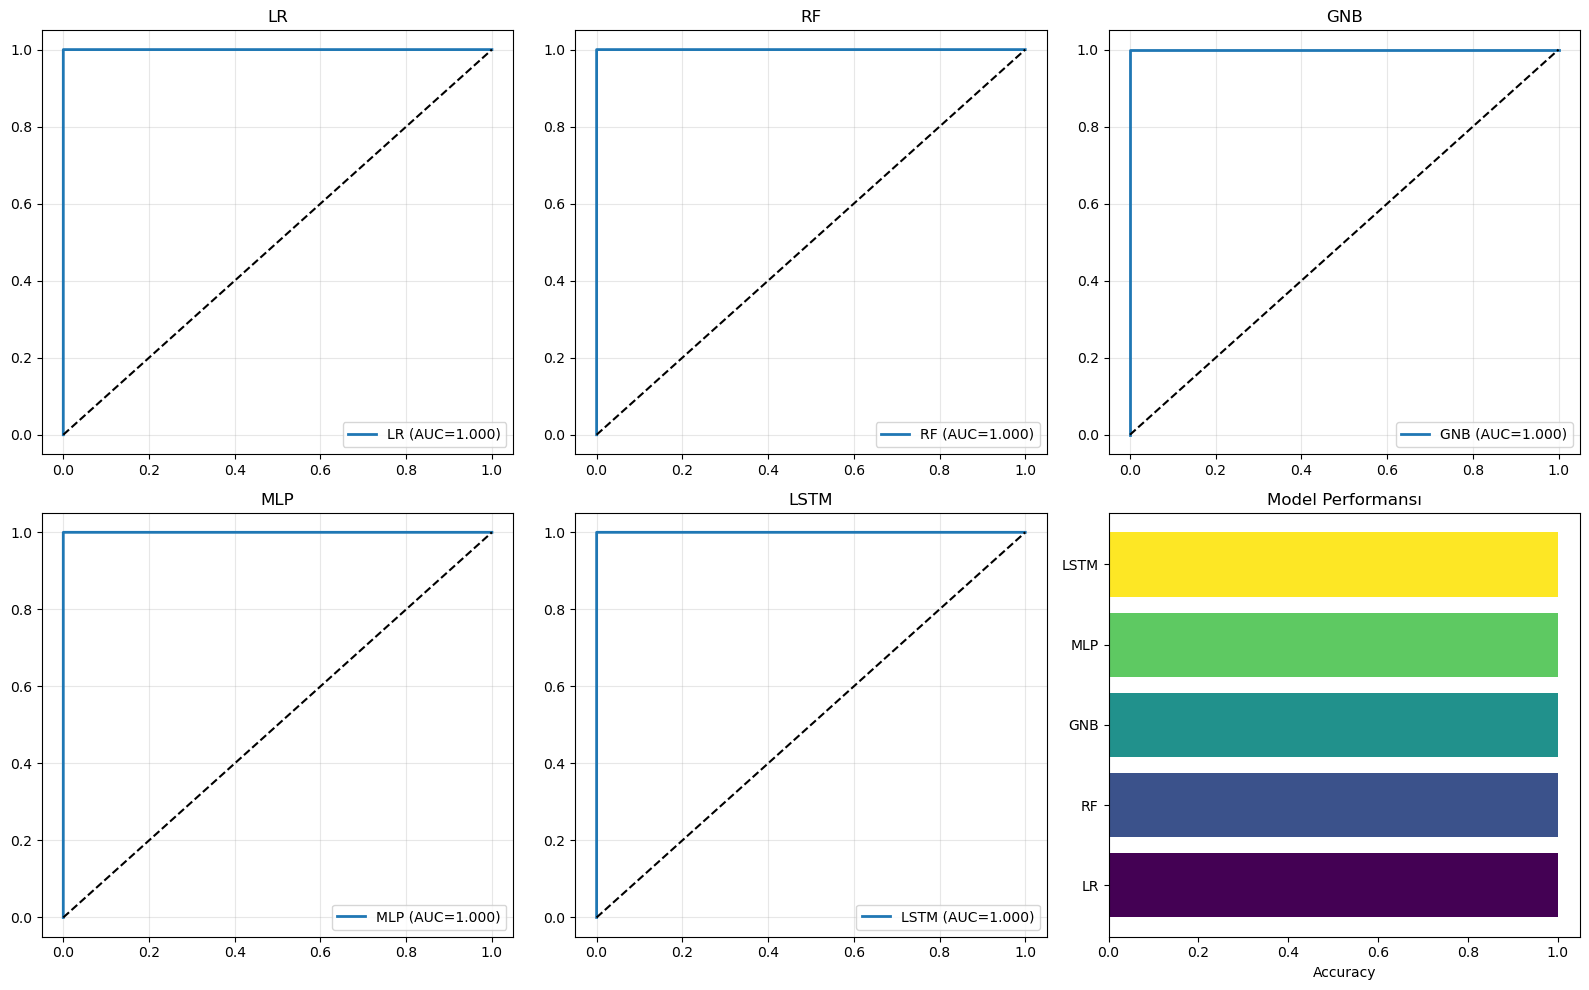

Kaydedildi: abdulkerim_class_distribution.png


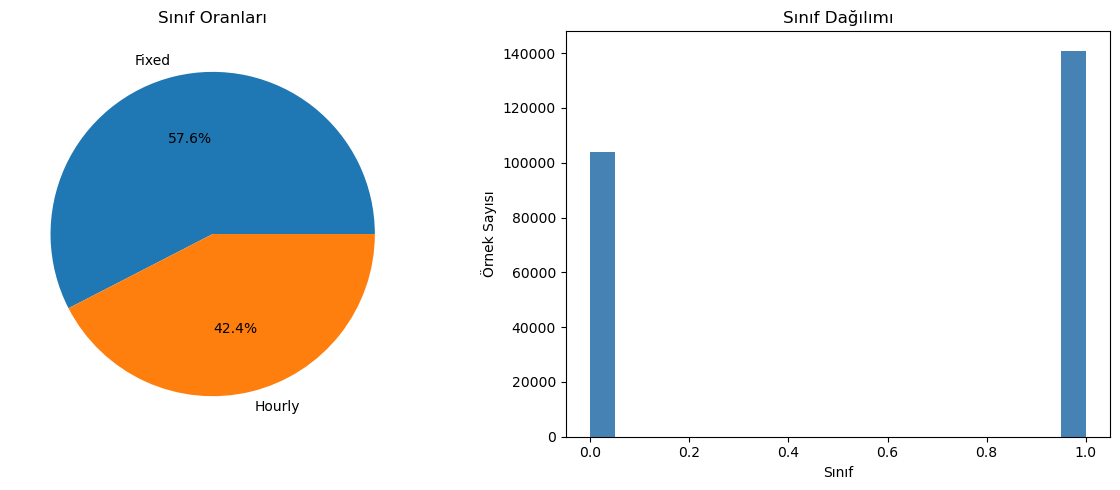


Abdulkerim için proje çalışması tamamlandı.


In [14]:
# =====================================================
# HÜCRE 10 – ROC EĞRİLERİ VE SINIF DAĞILIMI GÖRSELLERİ
# Bu hücre:
# 1) Her model için ROC eğrilerini tek figürde çizer
# 2) Modellerin doğruluklarını bar grafikle gösterir
# 3) Sınıf dağılımını pie ve histogram ile gösterir
# =====================================================

# ROC eğrileri ve doğruluk karşılaştırması
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

for y_proba, label, ax in [
    (y_prob_lr, "LR", axes[0, 0]),
    (y_prob_rf, "RF", axes[0, 1]),
    (y_prob_gnb, "GNB", axes[0, 2]),
    (y_prob_mlp, "MLP", axes[1, 0]),
    (y_prob_lstm, "LSTM", axes[1, 1])
]:
    fpr, tpr, _ = roc_curve(y_test_np, y_proba)
    auc = roc_auc_score(y_test_np, y_proba)
    ax.plot(fpr, tpr, label=f"{label} (AUC={auc:.3f})", linewidth=2)
    ax.plot([0, 1], [0, 1], "k--")
    ax.set_title(label)
    ax.legend()
    ax.grid(alpha=0.3)

# Doğruluk bar grafiği
ax = axes[1, 2]
ax.barh(
    ["LR", "RF", "GNB", "MLP", "LSTM"],
    [accuracy_score(y_test_np, y) for y in [
        y_pred_lr, y_pred_rf, y_pred_gnb, y_pred_mlp, y_pred_lstm
    ]],
    color=plt.cm.viridis(np.linspace(0, 1, 5))
)
ax.set_xlabel("Accuracy")
ax.set_title("Model Performansı")

plt.tight_layout()
plt.savefig("abdulkerim_roc_curves_comparison_fast.png", dpi=200, bbox_inches="tight")
print("Kaydedildi: abdulkerim_roc_curves_comparison_fast.png")
plt.show()

# Sınıf dağılımı
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].pie(
    pd.Series(y).value_counts(),
    labels=["Fixed", "Hourly"],
    autopct="%1.1f%%"
)
axes[0].set_title("Sınıf Oranları")

axes[1].hist(y, bins=20, color="steelblue")
axes[1].set_title("Sınıf Dağılımı")
axes[1].set_xlabel("Sınıf")
axes[1].set_ylabel("Örnek Sayısı")

plt.tight_layout()
plt.savefig("abdulkerim_class_distribution.png", dpi=200, bbox_inches="tight")
print("Kaydedildi: abdulkerim_class_distribution.png")
plt.show()

print("\nAbdulkerim için proje çalışması tamamlandı.")
